# 2. 通过 PyTorch 构建神经网络

_Kevin Siswandi_  
_Deep Learning Nanodegree_  

深度学习网络一般量级都很大，包含数百个层级，这也是为什么叫“深度”学习网络。你可以像在上个 notebook 展示的一样，仅使用权重矩阵构建深度网络，但是这通常很繁琐并且不好实施。PyTorch 有一个很方便的模块 `nn`，可以有效地构建大型神经网络。

In [1]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

现在我们要构建一个大型网络，并用它解决识别图像中的文字的这一难题。我们将使用 MNIST 数据集，这个数据集由灰色的手写数字组成。每个图像都是 28x28，如以下示例所示：

<img src='assets/mnist.png'>

我们的目标是构建一个神经网络，可以预测图像中的数字。

首先，我们需要获取数据集。这些数据位于 `torchvision` 软件包中。以下代码将下载 MNIST 数据集，然后为我们创建训练数据集和测试数据集。

In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Extracting /Users/kevinsiswandi/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /Users/kevinsiswandi/.pytorch/MNIST_data/MNIST/raw


Extracting /Users/kevinsiswandi/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/kevinsiswandi/.pytorch/MNIST_data/MNIST/raw


Extracting /Users/kevinsiswandi/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/kevinsiswandi/.pytorch/MNIST_data/MNIST/raw


Extracting /Users/kevinsiswandi/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/kevinsiswandi/.pytorch/MNIST_data/MNIST/raw
Processing...



Done!


/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


我们将训练数据加载到 `trainloader` 中，并使用 `iter(trainloader)` 使其变成迭代器。之后，我们将用它循环访问数据集以进行训练，例如

```python
for image, label in trainloader:
    ## do things with images and labels
```

我在创建 `trainloader` 时，将批次大小设为 64，并设置为 `shuffle=True`。批次大小是指我们在一次迭代中从数据加载器获取并经过网络的图像数量。`shuffle=True` 表示每次重新访问数据加载器时，随机重排数据集。但是现在我仅获取第一批数据，以便查看数据。从下方可以看出，`images` 是一个张量，大小为 `(64, 1, 28, 28)`。因此，每批有 64 个图像，图像有 1 个颜色通道，共有 28x28 个图像。

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


下面是一个图像示例。

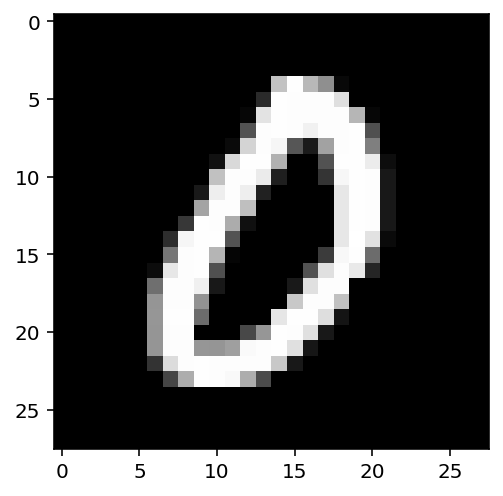

In [4]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

首先，我们要使用权重矩阵和矩阵乘法，用此数据集构建一个简单的网络。然后，我们将学习如何使用 PyTorch 的 `nn` 模块构建该网络。

神经网络又称为*全连接*或*密集*网络。一个层级中的每个单元都与下个层级中的每个单元相连。在全连接网络中，每个层级的输入必须是一维向量（可以作为一批样本堆叠为二维张量）。但是，我们的图像是 28x28 二维张量，因此我们需要将其转换为一维向量。考虑到大小问题，我们需要将形状为 `(64, 1, 28, 28)` 的批次图像变形为 `(64, 784)`，784 等于 28 x 28。这一步通常称为*扁平化*，我们将二维图像扁平化为一维向量。

之前，我们试过了构建具有一个输出单元的简单网络。现在，我们需要 10 个输出单元，每个数字对应一个单元。如果要预测出图像中显示的数字，我们必须计算该图像属于任何数字或类别的概率。我们会得到一个离散概率分布，告诉我们图像最有可能属于哪个类别。这就是说，我们需要 10 个输出单元，对应 10 个类别（数字）。下面讲解如何将网络输出转换为概率分布。

> **练习：**将 `images`扁平化。然后构建一个多层网络，有 784 个输入单元、256 个隐藏单元和 10 个输出单元，并对权重和偏差使用随机张量。目前，我们对隐藏层使用 sigmoid 激活函数。输出层暂时不需要激活函数，下一步我们将添加计算概率分布的激活函数。

In [5]:
## Exercise solution
def activation(x):
    return 1/(1+torch.exp(-x))

# Flatten the input images
inputs = images.view(images.shape[0], -1)

# Create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)

out = torch.mm(h, w2) + b2 # output of your network, should have shape (64,10)

现在网络有 10 个输出了。我们向网络中传入一个图像，并获得类别概率分布，告诉我们图像最有可能属于哪个数字/类别。结果如下所示：

<img src='assets/image_distribution.png' width=500px>

可以看出每个类别的概率大致相等。这是未训练网络的结果，网络尚未见过任何数据，因此返回均匀分布，每个类别的概率相等。

可以用 [**softmax** 函数](https://en.wikipedia.org/wiki/Softmax_function)计算概率分布。数学公式为：

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

它会将每个输入 $x_i$ 都缩放到 0 和 1 之间并标准化值，得出标准概率分布，其中概率总和是 1。

> **练习：**实现一个进行 softmax 运算的函数 `softmax` ，并针对批次中的每个样本返回概率分布。注意，在运算时需要注意形状。如果有一个张量 `a` 的形状为 `(64, 10)`，另一个张量 `b` 的形状为 `(64,)`，进行 `a/b` 运算将出错，因为 PyTorch 会对列进行除法运算（称为广播），但是大小不匹配。提示：对于 64 个样本中的每个样本，你可以除以一个值，即分母中的和。因此需要使 `b` 变形为 `(64, 1)`。这样的话，PyTorch 将使 `a` 中每行的10 个值除以 `b` 中每行的一个值。另外，要注意求和的方式。你要在 `torch.sum` 中定义 `dim` 。 `dim=0` 会对行求和，而 `dim=1` 会对列求和。

In [6]:
# solution to the exercise
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

# Here, out should be the output of the network in the previous excercise with shape (64,10)
probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


PyTorch 提供了`nn`模块，大大地简化了网络构建过程。我将演示如何构建上述同一个网络，即包含 784 个输入、256 个隐藏单元、10 个输出单元和一个 softmax 输出。

In [7]:
from torch import nn

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

分步讲解。
```python
class Network(nn.Module):
```
先继承 `nn.Module`。与 `super().__init__()` 相结合，创建一个跟踪架构的类，并提供大量有用的方法和属性。注意，在为网络创建类时，必须继承 `nn.Module`。类可以随意命名。
```python
self.hidden = nn.Linear(784, 256)
```
这行创建一个线性转换模块 $x\mathbf{W} + b$，其中有 784 个输入和 256 个输出，并赋值给 `self.hidden`。该模块会自动创建权重和偏差张量，供我们在 `forward` 方法中使用。创建网络 (`net`) 后，你可以使用 `net.hidden.weight` 和 `net.hidden.bias` 访问权重和偏差张量。
```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```
然后，我定义了 sigmoid 激活函数和 softmax 输出的运算。在 `nn.Softmax(dim=1)` 中设置 `dim=1` 会计算各个列的 softmax 值。
```python
def forward(self, x):
```
用 `nn.Module` 创建的 PyTorch 网络必须定义 `forward` 方法。它会接受一个张量 `x` 并将其传入你在 `__init__` 方法中定义的运算。
```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```
我们将输入张量 `x` 传入重新赋值给 `x` 的每个运算。可以看出输入张量经过隐藏层，然后经过 S 型函数、输出层，最终经过 softmax 函数。变量可以命名为任何名称，只要运算的输入和输出与你要构建的网络架构匹配即可。你在 `__init__` 方法中的定义顺序不重要，但是需要在 `forward` 方法中正确地设定运算顺序。

现在我们可以创建一个 `Network` 对象。

In [9]:
# Create the network and look at it's text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

你可以使用 `torch.nn.functional` 模块来更简练清晰地定义网络。这是最常见的网络定义方式，因为很多运算是简单的元素级函数。我们通常将此模块导入为 `F`，即 `import torch.nn.functional as F`。

In [10]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

## 2.1 激活函数

到目前为止，我们只学习了 softmax 激活函数，但是通常任何函数都可以用作激活函数。但是，要使网络能逼近非线性函数，激活函数必须是非线性函数。下面是一些常见的激活函数示例：Tanh（双曲正切）和 ReLU（修正线性单元）。

<img src="assets/activation.png" width=700px>

在实践中，ReLU 几乎一直用作隐藏层激活函数。

<img src="assets/mlp_mnist.png" width=600px>

> **练习：**请创建如下网络：输入层有 784 个单元，然后是有 128 个单元的隐藏层和一个 ReLU 激活函数，接着是有 64 个单元的隐藏层和一个 ReLU 激活函数，最终是一个应用 softmax 激活函数的输出层（如上所示）。你可以通过 `nn.ReLU` 模块或 `F.relu` 函数应用 ReLU 激活函数。

It's good practice to name your layers by their type of network, for instance 'fc' to represent a fully-connected layer. As you code your solution, use `fc1`, `fc2`, and `fc3` as your layer names.

In [11]:
## Solution to the exercise
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## 2.2 初始化权重和偏差

权重和偏差会自动初始化，但是你可以自定义它们的初始化方式。权重和偏差是附加到所定义层级上的张量，例如，你可以通过 `model.fc1.weight` 获取权重。

In [12]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[-0.0262, -0.0035, -0.0142,  ..., -0.0078, -0.0074, -0.0067],
        [ 0.0285,  0.0348,  0.0119,  ...,  0.0329,  0.0182,  0.0325],
        [-0.0236, -0.0260, -0.0226,  ..., -0.0227,  0.0208,  0.0030],
        ...,
        [ 0.0074, -0.0100,  0.0311,  ..., -0.0331, -0.0073,  0.0230],
        [ 0.0076, -0.0109,  0.0331,  ..., -0.0012,  0.0113, -0.0354],
        [ 0.0033,  0.0054,  0.0278,  ...,  0.0313,  0.0288,  0.0053]],
       requires_grad=True)
Parameter containing:
tensor([ 3.2113e-02,  6.4867e-03, -2.1056e-02,  4.6700e-03,  1.5684e-02,
         1.6135e-02,  2.5165e-02, -1.9087e-02,  3.0604e-02,  2.3650e-02,
        -8.3562e-03,  1.1718e-02,  3.2351e-02, -1.9140e-02, -6.6163e-03,
         2.4622e-02, -2.9545e-02, -2.2153e-02,  1.8051e-02, -1.5328e-02,
         2.3926e-02, -2.6248e-02,  2.8198e-03, -3.2471e-02,  1.2365e-02,
         1.0111e-02,  2.3075e-02, -1.5615e-02,  1.4654e-02, -3.2670e-02,
         8.5102e-03, -1.1770e-02, -7.9423e-03, -3.1486e-0

要自定义初始化过程，我们需要原地修改这些张量。这些实际上是 autograd *变量*，因此我们需要使用 `model.fc1.weight.data` 获取实际张量。获得张量后，我们可以用 0（对于偏差）或随机正常值填充这些张量。

In [13]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 0.0087, -0.0206,  0.0120,  ...,  0.0041,  0.0072,  0.0129],
        [ 0.0138, -0.0106, -0.0044,  ..., -0.0085,  0.0104,  0.0053],
        [ 0.0155, -0.0007,  0.0056,  ..., -0.0118,  0.0002,  0.0022],
        ...,
        [-0.0036, -0.0084,  0.0026,  ..., -0.0183,  0.0111, -0.0232],
        [-0.0210, -0.0035, -0.0030,  ...,  0.0045,  0.0002, -0.0144],
        [ 0.0146, -0.0019, -0.0121,  ..., -0.0103, -0.0128, -0.0015]])

## 2.3 前向传递

我们已经创建好网络，看看传入图像后会发生什么。

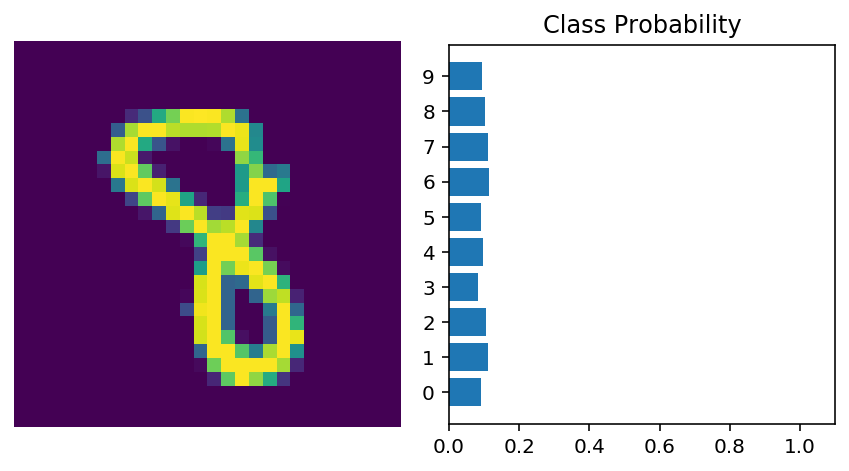

In [15]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

是的，我们的网络还不能判断出这个数字。这是因为我们尚未训练它，所有权重都是随机的！

## 2.4 使用 `nn.Sequential`

PyTorch 提供了一种方便的方法来构建这类网络（其中张量按顺序执行各种运算）：`nn.Sequential` ([文档](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential))。使用它来构建等效网络：

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


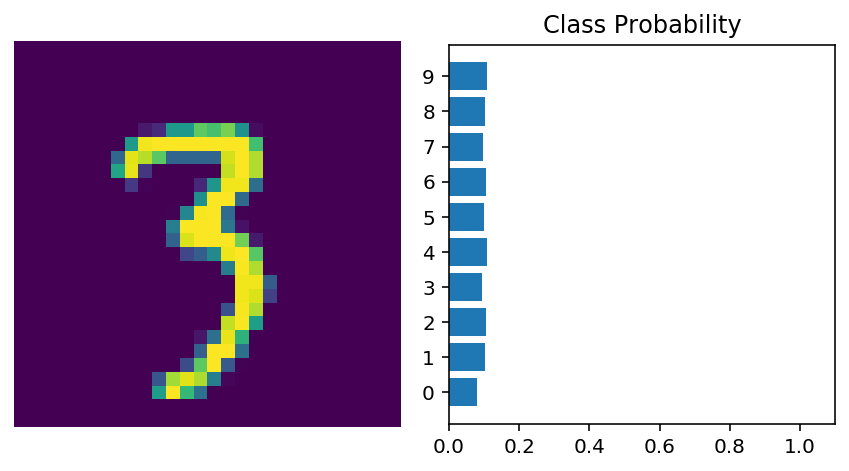

In [16]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

模型和之前一样：输入层有 784 个单元，然后是有 128 个单元的隐藏层和一个 ReLU 激活函数，然后是有 64 个单元的隐藏层和另一个 ReLU 激活函数，然后是有 10 个单元的输出层和 softmax 输出。

通过传入相应的索引即可执行运算。例如，如果你想获得第一个线性运算并查看权重，可以使用 `model[0]`。

In [17]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[ 0.0294,  0.0353,  0.0337,  ..., -0.0114,  0.0193,  0.0263],
        [-0.0115,  0.0221,  0.0150,  ..., -0.0124, -0.0081,  0.0118],
        [-0.0060,  0.0096,  0.0144,  ..., -0.0090,  0.0156,  0.0259],
        ...,
        [ 0.0044, -0.0317,  0.0284,  ...,  0.0043,  0.0324,  0.0290],
        [-0.0156,  0.0157,  0.0140,  ..., -0.0333, -0.0337,  0.0271],
        [ 0.0337, -0.0285, -0.0075,  ...,  0.0133, -0.0066,  0.0164]],
       requires_grad=True)

还可以传入 `OrderedDict` 以命名单个层级和运算，而不是使用递增的整数。注意，因为字典键必须是唯一的，所以每个运算都必须具有不同的名称。

In [18]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

现在你可以通过整数或名称访问层级了.

In [19]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


在下个 notebook 中，我们将学习如何训练神经网络，以便准确预测 MNIST 图像中出现的数字。